In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from keras import backend as K
from keras import (
    layers,
    models,
    losses,
    metrics,
    utils,
    optimizers,
    callbacks
)

import pandas as pd

2024-02-20 13:28:14.214462: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 13:28:14.214568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 13:28:14.377924: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#variables
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

**Prepare the Data**

In [3]:
train_data = utils.image_dataset_from_directory(
    "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle = True,
    seed=42,
    interpolation="bilinear"
)

Found 202599 files belonging to 1 classes.


In [4]:
#preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

train = train_data.map(lambda x: preprocess(x))

In [5]:
# get a batch of images from the train_data

def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    
    # check if batch is instance of a tuple
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

In [6]:
#function to display images

def display(images, n=10, size=(20,3), cmap="gray_r", as_type="float32", save_to=None):
  #display random images from each of the supplied arrays

  if images.max() > 1.0:
    images = images / 255.0
  elif images.min() < 0.0:
    images = (images + 1.0) /2.0

  plt.figure(figsize=size)
  for i in range(n):
    _ = plt.subplot(1, n, i + 1)
    plt.imshow(images[i].astype(as_type), cmap=cmap)
    plt.axis("off")

  if save_to:
    plt.savefig(save_to)
    print(f"\Saved to {save_to}")

  plt.show()

In [7]:
train_sample = sample_batch(train)

In [8]:
train_sample.shape

(128, 64, 64, 3)

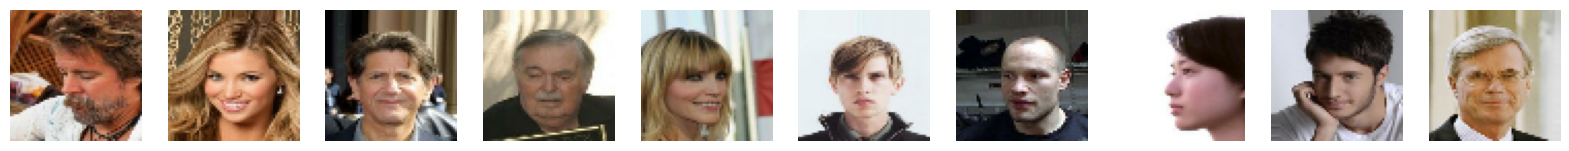

In [9]:
display(train_sample, cmap=None)

### Build the Variational AutoEncoder

In [10]:
# define the sampling layer

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [11]:
#define the encoder
encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input")

x = layers.Conv2D(
    NUM_FEATURES,
    3,
    strides=2,
    padding="same"
)(encoder_input)

x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(
    NUM_FEATURES,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(
    NUM_FEATURES,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(
    NUM_FEATURES,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# flatten to vector before dense layer
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)

z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 128)          3584      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 128)          512       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)          0         ['batch_normalization[0]

In [12]:
# define the decoder

decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")

#connect the input to a dense layer
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)

x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

#reshape this vector into a tensor that can be fed as input into Conv2DTranspose
x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(
    NUM_FEATURES,
    3,
    strides=2,
    padding="same"
)(x)

x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(
    NUM_FEATURES,
    3,
    strides=2,
    padding="same"
)(x)

x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(
    NUM_FEATURES,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(
    NUM_FEATURES,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# x = layers.Conv2DTranspose(
#     NUM_FEATURES,
#     3,
#     strides=2,
#     padding="same"
# )(x)
# x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU()(x)

decoder_output = layers.Conv2DTranspose(
    CHANNELS,
    3,
    strides=1,
    activation="sigmoid",
    padding="same"
)(x)

decoder = models.Model(decoder_input, decoder_output)

decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 2048)              411648    
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                    

In [13]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [14]:
# create the variational autoencoder

vae = VAE(encoder, decoder)

### Train the VAE

In [15]:
# compile the VAE
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [16]:
import os
output_directory = './output/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

In [17]:
# save checkpoints to monitor best performing models

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only = False,
    save_freq = "epoch",
    monitor = "loss",
    mode = "min",
    save_best_only = True,
    verbose = 0
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# subclass of the callback class

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        
        """generates a tensor of random values from a normal distribution, where each row represents a random vector in a latent space"""
        # num of rows is determined by self.num_img
        # dimensionality of each vector is self.latent_dim
        
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *=255
        generated_images = generated_images.numpy()
        
        display(generated_images)
#         for i in range(self.num_img):
#             img = utils.array_to_img(generated_images[i])
#             display(generated_images)
#            img.save(os.path.join(output_directory, "generated_img_%03d_%d.png" % (epoch, i)))

In [18]:
# load old weights if required

if LOAD_MODEL:
    vae.load_weights("./models/vae")
    tmp = vae.predict(train.take(1))

Epoch 1/10


I0000 00:00:1708436115.818579      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1583/1583 [==============================] - ETA: 0s - loss: 95.5877 - reconstruction_loss: 60.0422 - kl_loss: 18.3865

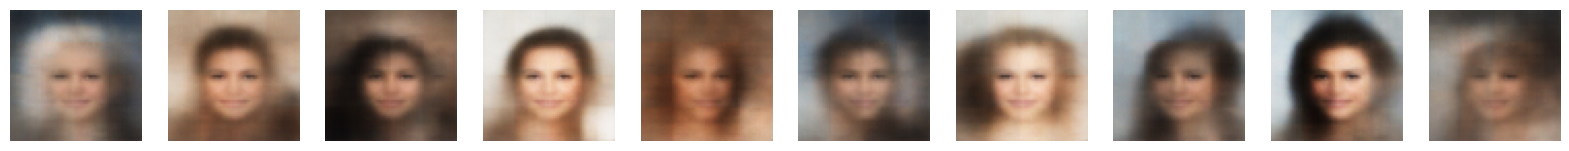

1583/1583 [==============================] - 308s 186ms/step - loss: 95.5769 - reconstruction_loss: 60.0422 - kl_loss: 18.3865
Epoch 2/10
1583/1583 [==============================] - ETA: 0s - loss: 68.3900 - reconstruction_loss: 49.7709 - kl_loss: 17.9158

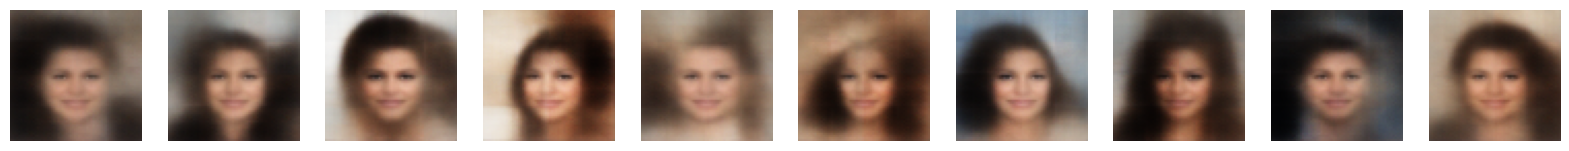

1583/1583 [==============================] - 231s 146ms/step - loss: 68.3895 - reconstruction_loss: 49.7709 - kl_loss: 17.9158
Epoch 3/10
1583/1583 [==============================] - ETA: 0s - loss: 66.5619 - reconstruction_loss: 48.2984 - kl_loss: 17.9968

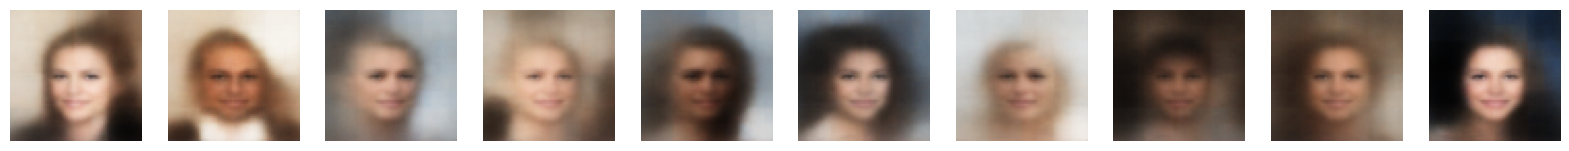

1583/1583 [==============================] - 231s 146ms/step - loss: 66.5617 - reconstruction_loss: 48.2984 - kl_loss: 17.9968
Epoch 4/10
1583/1583 [==============================] - ETA: 0s - loss: 65.7775 - reconstruction_loss: 47.5574 - kl_loss: 18.0270

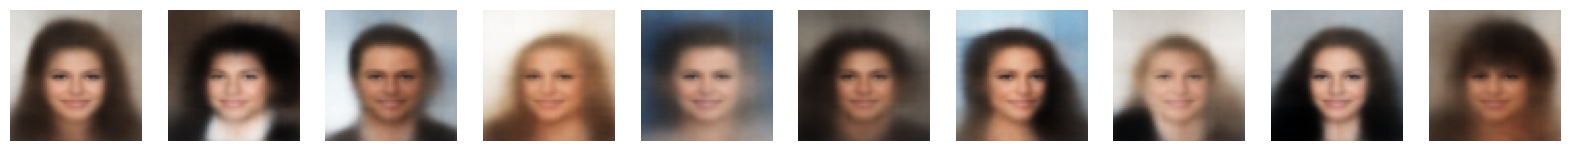

1583/1583 [==============================] - 231s 145ms/step - loss: 65.7774 - reconstruction_loss: 47.5574 - kl_loss: 18.0270
Epoch 5/10
1583/1583 [==============================] - ETA: 0s - loss: 65.2078 - reconstruction_loss: 47.0380 - kl_loss: 18.0507

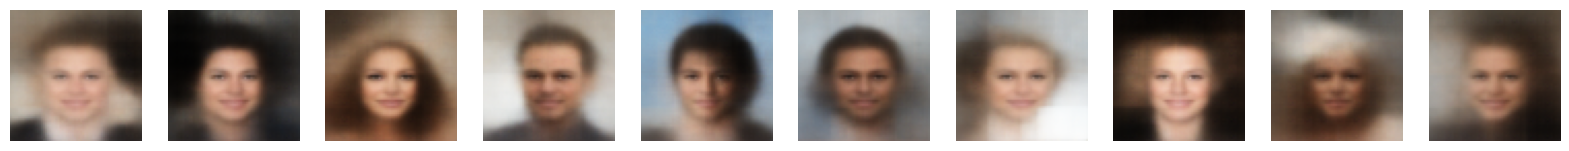

1583/1583 [==============================] - 231s 146ms/step - loss: 65.2078 - reconstruction_loss: 47.0380 - kl_loss: 18.0507
Epoch 6/10
1583/1583 [==============================] - ETA: 0s - loss: 64.8313 - reconstruction_loss: 46.5828 - kl_loss: 18.1029

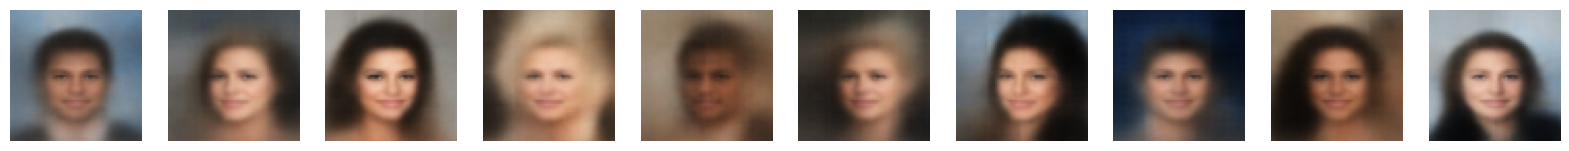

1583/1583 [==============================] - 231s 146ms/step - loss: 64.8312 - reconstruction_loss: 46.5828 - kl_loss: 18.1029
Epoch 7/10
1583/1583 [==============================] - ETA: 0s - loss: 64.4970 - reconstruction_loss: 46.2601 - kl_loss: 18.1126

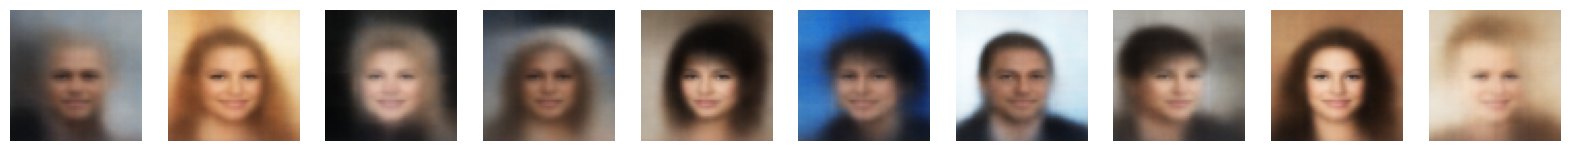

1583/1583 [==============================] - 231s 146ms/step - loss: 64.4970 - reconstruction_loss: 46.2601 - kl_loss: 18.1126
Epoch 8/10
1583/1583 [==============================] - ETA: 0s - loss: 64.2450 - reconstruction_loss: 46.0164 - kl_loss: 18.1291

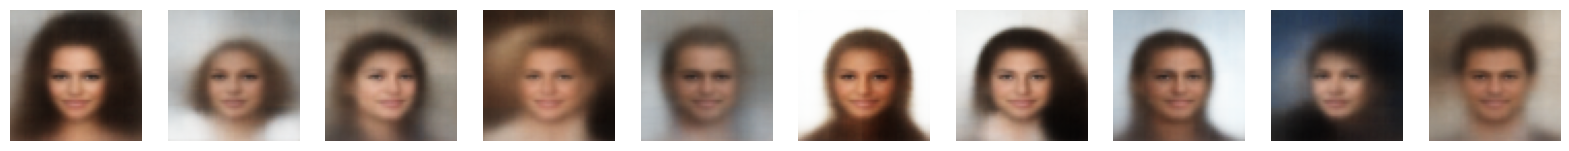

1583/1583 [==============================] - 231s 146ms/step - loss: 64.2450 - reconstruction_loss: 46.0164 - kl_loss: 18.1291
Epoch 9/10
1583/1583 [==============================] - ETA: 0s - loss: 64.0169 - reconstruction_loss: 45.7640 - kl_loss: 18.1411

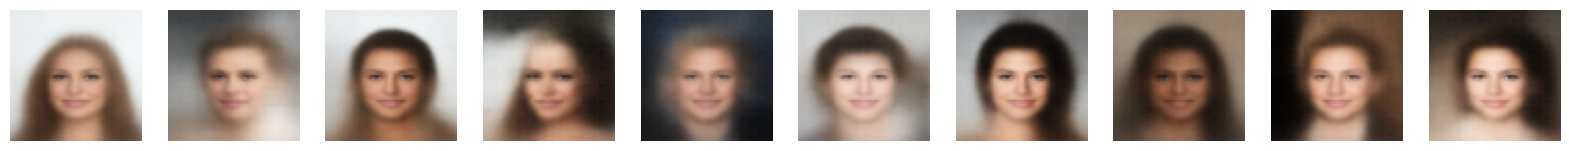

1583/1583 [==============================] - 231s 146ms/step - loss: 64.0169 - reconstruction_loss: 45.7640 - kl_loss: 18.1411
Epoch 10/10
1583/1583 [==============================] - ETA: 0s - loss: 63.7756 - reconstruction_loss: 45.5488 - kl_loss: 18.1322

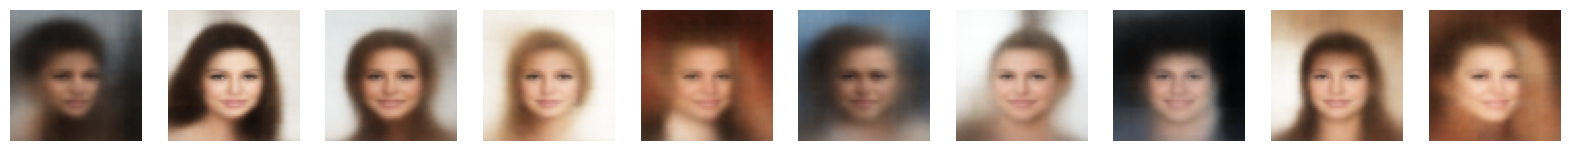

1583/1583 [==============================] - 231s 145ms/step - loss: 63.7756 - reconstruction_loss: 45.5488 - kl_loss: 18.1322


In [19]:
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [20]:
# save the final models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

### Reconstruct the VAE

In [21]:
# select a subset of the test set
batches_to_predict = 1

example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 [==============================] - 1s 10ms/step
Example real faces


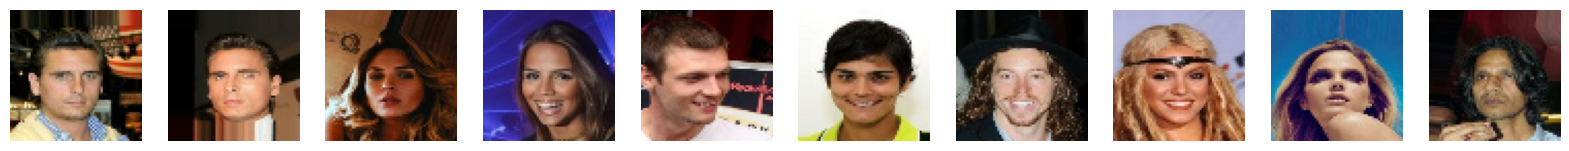

Reconstructions


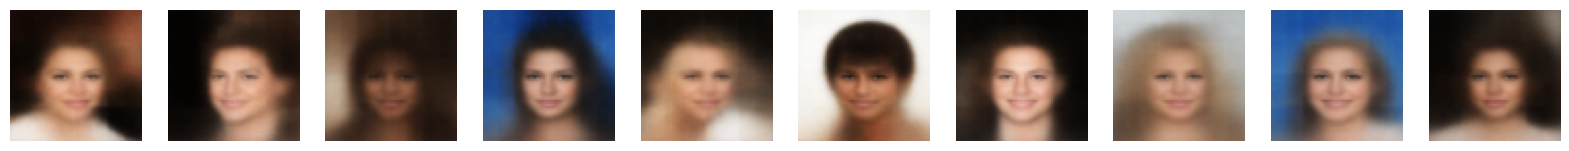

In [22]:
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

In [23]:
reconstructions[1]

array([[[0.03562351, 0.02653526, 0.02056389],
        [0.03141369, 0.02316486, 0.01681982],
        [0.02815193, 0.0198154 , 0.01480432],
        ...,
        [0.18397522, 0.11530728, 0.08168546],
        [0.18368696, 0.11769372, 0.08495264],
        [0.20317264, 0.13601202, 0.10412795]],

       [[0.03033604, 0.02309511, 0.01773273],
        [0.02652794, 0.02026954, 0.01461726],
        [0.02427768, 0.01799242, 0.01393674],
        ...,
        [0.18889053, 0.12357862, 0.08528826],
        [0.1882171 , 0.12024412, 0.08624   ],
        [0.19776432, 0.12936984, 0.09669163]],

       [[0.02677237, 0.01999954, 0.01432893],
        [0.02312163, 0.01707048, 0.01256982],
        [0.02270031, 0.01639656, 0.0117812 ],
        ...,
        [0.1867143 , 0.11822643, 0.08335895],
        [0.18529034, 0.11955664, 0.08356662],
        [0.20103118, 0.13184267, 0.09788822]],

       ...,

       [[0.07550679, 0.05908127, 0.04588135],
        [0.07305142, 0.05744801, 0.04527069],
        [0.07022735, 0